<a href="https://www.kaggle.com/code/mdmofazzalhossaingub/working-xception-lstm-model-for-har?scriptVersionId=248431699" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# install librarires
import os
import tensorflow as tf
import numpy as np
import random

2025-07-02 05:24:08.462091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751433848.705495      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751433848.774390      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# global variables
# set dataset directories


DATASET_DIR = "/kaggle/input/msrdailyactivity3d-rgb-videos-only"
ALL_CLASS_NAMES = os.listdir(DATASET_DIR)

# Global constant variables -> 
NO_OF_CLASSES = 16
CLASSES_LIST = ALL_CLASS_NAMES[:NO_OF_CLASSES]

# Model Configuration
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 15

# set drop out rate
DROPOUT_RATE = 0.3

# set datas
MAX_VIDEO_PER_CLASS = 20

# split dataset
TEST_SIZE = 0.20

# model fit parameters
EPOCHS = 50
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.40


# give a name of the model to save
MODEL_NAME = "Xception"

print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS}/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

There are total 16 classes, selected 16 classes
Setting 20/class to train the model.
Image size 128x128 with 15 sequence length
Dropout rate: 0.3
Train-Test split ratio 80/20
Validation data from Train set 40.0%


In [3]:
# set seeed to get similar values
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
import cv2
from concurrent.futures import ThreadPoolExecutor

def resize_and_normalize_frame(frame, image_height, image_width):
    try:
        resized_frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_LINEAR)
        normalized_frame = resized_frame / 255.0
        return normalized_frame
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None

def frames_extraction(video_path, 
                      sequence_length=SEQUENCE_LENGTH, 
                      image_height=IMAGE_HEIGHT, 
                      image_width=IMAGE_WIDTH):
    # Declare a list to store video frames
    frames_list = []

    # Check if video file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None

    # Read the video file using VideoCapture with optimized settings
    video_reader = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)

    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        video_reader.release()
        return None

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ensure the video has enough frames
    if video_frames_count < sequence_length:
        print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
        video_reader.release()
        return None

    # Calculate the interval after which frames will be sampled
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Pre-allocate frame indices to extract
    frame_indices = [i * skip_frames_window for i in range(sequence_length)]

    # Read and process frames in parallel
    frames = []
    for idx in frame_indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success or frame is None:
            print(f"Warning: Failed to read frame at index {idx} from {video_path}")
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    # Release the VideoCapture object early
    video_reader.release()

    # Ensure the correct number of frames is read
    if len(frames) != sequence_length:
        print(f"Warning: Read {len(frames)} frames instead of {sequence_length} from {video_path}")
        return None

    # Process frames in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        processed_frames = list(executor.map(
            lambda f: resize_and_normalize_frame(f, image_height, image_width), 
            frames
        ))

    # Check for any failed frame processing
    if any(f is None for f in processed_frames):
        print(f"Warning: Some frames failed to process in {video_path}")
        return None

    # Convert to NumPy array
    frames_array = np.array(processed_frames, dtype=np.float32)

    return frames_array

In [5]:
# RUN create dataset function definition
def create_dataset(dataset_dir,
                   classes_list, 
                   sequence_length=SEQUENCE_LENGTH, 
                   image_height=IMAGE_HEIGHT, 
                   image_width=IMAGE_WIDTH, 
                   max_videos_per_class=None,
                   augmentations=False
                  ):
    
    # Initialize lists to store features, labels, and video file paths
    features = []
    labels = []

    # Check if dataset directory exists
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

    # Iterate through all classes in the classes list
    for class_index, class_name in enumerate(classes_list):
        class_path = os.path.join(dataset_dir, class_name)
        
        # Check if class directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files in the class directory
        files_list = os.listdir(class_path)

        # Limit the number of videos if specified
        if max_videos_per_class is not None:
            files_list = files_list[:max_videos_per_class]

        # Iterate through all video files
        for file_name in files_list:
            video_file_path = os.path.join(class_path, file_name)

            # Extract frames using the updated frames_extraction function
            frames = frames_extraction(video_file_path, sequence_length, image_height, image_width)

            # Skip videos where frame extraction failed
            if frames is None:
                print(f"Skipping video {video_file_path} due to frame extraction failure")
                continue

            # Append the data to respective lists
            features.append(frames)
            labels.append(class_index)

    # Convert lists to numpy arrays
    if not features:
        raise ValueError("No valid videos were processed. Check dataset or parameters.")
    features = np.asarray(features)
    labels = np.array(labels)

    print(f"Dataset created with {len(features)} videos")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")

    return features, labels

In [6]:
# RUN Create the dataset with explicit parameters
try:
    features, labels = create_dataset(
        dataset_dir=DATASET_DIR,
        classes_list=CLASSES_LIST,
        sequence_length=SEQUENCE_LENGTH,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        # Limit to 10 videos per class to manage memory
        augmentations=True,
        max_videos_per_class=MAX_VIDEO_PER_CLASS
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

features.shape, labels.shape

Extracting Data of Class: write on a paper
Extracting Data of Class: use laptop
Extracting Data of Class: read book
Extracting Data of Class: sit still
Extracting Data of Class: drink
Extracting Data of Class: sit down
Extracting Data of Class: use vacuum cleaner
Extracting Data of Class: eat
Extracting Data of Class: play guitar
Extracting Data of Class: lie down on sofa
Extracting Data of Class: stand up
Extracting Data of Class: toss paper
Extracting Data of Class: walk
Extracting Data of Class: play game
Extracting Data of Class: cheer up
Extracting Data of Class: call cellphone
Dataset created with 320 videos
Features shape: (320, 15, 128, 128, 3)
Labels shape: (320,)


((320, 15, 128, 128, 3), (320,))

In [7]:
features.shape

(320, 15, 128, 128, 3)

In [8]:
# all videos shape -> (No of videos, sequence length, height, width, color channel)
print(features.shape)

# single video shape -> (sequence length, height, width, color channel)
features[0].shape

(320, 15, 128, 128, 3)


(15, 128, 128, 3)

In [9]:
# show frame def
import matplotlib.pyplot as plt

def show_frame(frame):
    plt.figure(figsize=(3,3))
    plt.imshow(frame)
    plt.axis("off")
    plt.tight_layout()

In [10]:
# reusable video loop helper function
def apply(function, videos, labels, *arg, **kwargs):
    new_videos=[]
    new_labels=[]
    combined=zip(labels, videos)
    
    for label, video in combined:
        new_videos.append(function(video, *arg, **kwargs))
        new_labels.append(label)
        
    new_videos=np.asarray(new_videos)
    new_labels=np.asarray(new_labels)
    
    return new_videos, new_labels

(15, 128, 128, 3)


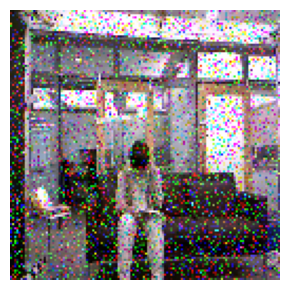

In [11]:
# Noise function def

def noise_video(video,noise_factor=0.2):
    noisy_video=[]
    for frame in video:
        # Generate random noise
        noise = np.random.rand(*frame.shape)  # Generate random noise
        salt_pepper_noise = np.random.choice([0, 1], size=frame.shape, p=[1-noise_factor, noise_factor])
        noisy_frame = frame * (1 - salt_pepper_noise) + salt_pepper_noise * np.random.rand(*frame.shape)
        noisy_video.append(noisy_frame)
    return np.array(noisy_video)

noised_video = noise_video(features[0])

print(noised_video.shape)
show_frame(noised_video[0])

In [12]:
augmented_features=[]
augmented_labels=[]

In [13]:
# apply noise
noise_videos, noise_labels = apply(noise_video, features, labels)

noise_videos.shape, noise_labels.shape

((320, 15, 128, 128, 3), (320,))

In [14]:
augmented_features = noise_videos
augmented_labels = noise_labels

augmented_features.shape, augmented_labels.shape

((320, 15, 128, 128, 3), (320,))

In [15]:
del noise_videos, noise_labels

I0000 00:00:1751433970.923271      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751433970.924007      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


(15, 128, 128, 3)

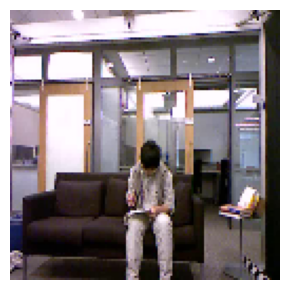

In [16]:
# horizontal flip function def
# Testing Flip feautes[0] -> first video
def horizontal_flip(video):
    return [tf.image.flip_left_right(frame) for frame in video]

flipped_video_1 = horizontal_flip(features[0])

flipped_video_1=np.asarray(flipped_video_1)

show_frame(flipped_video_1[0])
flipped_video_1.shape


In [17]:
# apply horizontal flip
flipped_videos, flipped_labels = apply(horizontal_flip, features, labels)

flipped_videos.shape, flipped_labels.shape

((320, 15, 128, 128, 3), (320,))

In [18]:
augmented_features = np.concatenate((augmented_features, flipped_videos), axis=0)
augmented_labels = np.concatenate((augmented_labels, flipped_labels), axis=0)

augmented_features.shape, augmented_labels.shape

((640, 15, 128, 128, 3), (640,))

In [19]:
del flipped_videos, flipped_labels

(320, 15, 128, 128, 3)
(15, 128, 128, 3)


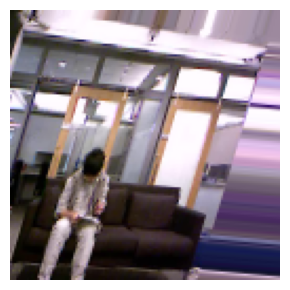

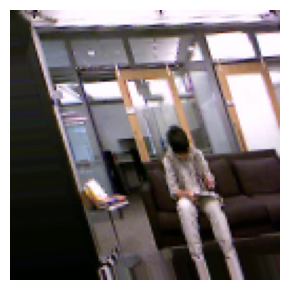

In [20]:
# random shear function def
import numpy as np
import tensorflow as tf
from scipy.ndimage import affine_transform

def apply_shear_frames(frames, shear_right):
    return [apply_shear(frame, shear_right) for frame in frames]

def apply_shear(frame, shear_right=0):
    frame_resized = tf.image.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH)).numpy()
    if shear_right:
        shear_x = 0.09
        shear_y = -0.3
    else:
        shear_x = -0.09
        shear_y = 0.3
    # Construct the affine matrix for scipy: inverse of the transformation matrix
    # scipy applies the inverse transform matrix
    shear_matrix = np.array([
        [1, shear_x, 0],
        [shear_y, 1, 0],
        [0, 0, 1]
    ], dtype=np.float32)

    # Extract 2x2 part for affine_transform
    matrix = shear_matrix[:2, :2]

    # Offset (no translation)
    offset = [0, 0]

    # Apply affine transform on each channel separately
    sheared = np.zeros_like(frame_resized)
    for c in range(3):
        sheared[..., c] = affine_transform(
            frame_resized[..., c],
            matrix=matrix,
            offset=offset,
            order=1,          # bilinear interpolation
            mode='nearest'    # fill_mode
        )
    return sheared

print(features.shape)

sheared_1 = apply_shear_frames(features[0], shear_right=0)
sheared_2 = apply_shear_frames(features[0], shear_right=1)

sheared_1 = np.asarray(sheared_1)
sheared_2 = np.asarray(sheared_2)

print(sheared_1.shape)
show_frame(sheared_1[0])
show_frame(sheared_2[0])

In [21]:
# apply shear left
sheared_videos, sheared_labels = apply(apply_shear_frames, features, labels, shear_right=0)

sheared_videos.shape, sheared_labels.shape

((320, 15, 128, 128, 3), (320,))

In [22]:
augmented_features = np.concatenate((augmented_features, sheared_videos), axis=0)
augmented_labels = np.concatenate((augmented_labels, sheared_labels), axis=0)

augmented_features.shape, augmented_labels.shape

((960, 15, 128, 128, 3), (960,))

In [23]:
# apply shear right
sheared_videos, sheared_labels = apply(apply_shear_frames, features, labels, shear_right=1)

sheared_videos.shape, sheared_labels.shape

((320, 15, 128, 128, 3), (320,))

In [24]:
augmented_features = np.concatenate((augmented_features, sheared_videos), axis=0)
augmented_labels = np.concatenate((augmented_labels, sheared_labels), axis=0)

augmented_features.shape, augmented_labels.shape

((1280, 15, 128, 128, 3), (1280,))

In [25]:
del sheared_videos, sheared_labels

In [26]:
# Video Data Generator def
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import numpy as np

class VideoDataGenerator(Sequence):
    def __init__(self, video_frames, labels, batch_size, is_training=False):
        self.video_frames = video_frames  # List of sequences, shape: (sequence_length, height, width, channels)
        self.labels = labels  # List or array of labels
        self.batch_size = batch_size
        self.indices = np.arange(len(self.video_frames))  # For shuffling
        self.is_training = is_training  # Flag to control whether augmentation is applied

        # Convert inputs to NumPy arrays, assuming frames are already normalized to [0, 1]
        self.video_frames = [np.array(seq, dtype=np.float32) for seq in self.video_frames]
        self.labels = np.array(self.labels)

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(len(self.video_frames) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Handle case where batch_indices is empty
        if len(batch_indices) == 0:
            return np.array([], dtype=np.float32), np.array([], dtype=np.float32)
        
        # Initialize lists to store frames and labels
        all_frames = []
        all_labels = []
        
        # Process each sequence in the batch
        for i, index in enumerate(batch_indices):
            sequence = self.video_frames[index]
            label = self.labels[index]
            
            if self.is_training:
                # Apply augmentations for training data
                augmented_sequences = self._augment_video(sequence)
                # augmented_sequences shape: (num_augmentations, sequence_length, height, width, channels)
                for aug_seq in augmented_sequences:
                    all_frames.append(aug_seq)
                    all_labels.append(label)  # Replicate the label for each augmented version
            else:
                # No augmentation for validation or test data
                all_frames.append(sequence)
                all_labels.append(label)
        
        # Convert to numpy arrays
        all_frames = np.array(all_frames, dtype=np.float32)
        all_labels = np.array(all_labels)
        
        return all_frames, all_labels

    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

    def as_dataset(self):
        def generator():
            for idx in range(len(self)):
                frames, labels = self[idx]
                # Skip empty batches
                if frames.size == 0:
                    continue
                yield frames, labels
    
        # Create a tf.data.Dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=(
                (None, self.video_frames[0].shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, self.video_frames[0].shape[3]),
                (None,) + self.labels.shape[1:]
            )
        )
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    def _augment_video(self, video):
        """
        Apply augmentations to a video. Returns all augmented versions.
        """
        augmented_versions = []
    
        # Original video
        augmented_versions.append(self.resize_video(video))
    
        # Apply horizontal flip (two versions)
        flipped_video_1 = [tf.image.flip_left_right(frame) for frame in video]
        flipped_video_2 = [tf.image.flip_left_right(frame) for frame in video]
        augmented_versions.append(self.resize_video(np.array(flipped_video_1)))
        augmented_versions.append(self.resize_video(np.array(flipped_video_2)))
    
        # Apply random shearing (two versions)
        shear_x = np.random.uniform(-0.09, 0.09)
        shear_y = np.random.uniform(-0.3, 0.3)
        sheared_video_1 = [self.apply_shear(frame, shear_x, shear_y) for frame in video]
        shear_x = np.random.uniform(-0.09, 0.09)
        shear_y = np.random.uniform(-0.3, 0.3)
        sheared_video_2 = [self.apply_shear(frame, shear_x, shear_y) for frame in video]
        augmented_versions.append(self.resize_video(np.array(sheared_video_1)))
        augmented_versions.append(self.resize_video(np.array(sheared_video_2)))
    
        # Apply salt & pepper noise
        noisy_video = self.add_salt_pepper_noise(video)
        augmented_versions.append(self.resize_video(noisy_video))
    
        return np.array(augmented_versions, dtype=np.float32)

    def apply_shear(self, frame, shear_x, shear_y):
        """
        Apply shear transformation to a single frame.
        """
        # Define the shear transformation matrix
        shear_matrix = np.array([
            [1, shear_x, 0],
            [shear_y, 1, 0],
            [0, 0, 1]
        ], dtype=np.float32)
    
        # Reshape frame to (height, width, channels) and apply affine transformation
        frame = tf.image.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frame = tf.keras.preprocessing.image.apply_affine_transform(
            frame.numpy(),
            shear=shear_y * 180 / np.pi,  # Convert to degrees if needed
            fill_mode='nearest'
        )
        return frame

    def resize_video(self, video, target_height=IMAGE_HEIGHT, target_width=IMAGE_WIDTH):
        """
        Resize each frame in the video to a consistent size.
        """
        resized_video = [tf.image.resize(frame, (target_height, target_width)) for frame in video]
        return np.array(resized_video)

    def add_salt_pepper_noise(self, video, noise_factor=0.02):
        """
        Adds salt and pepper noise to the video (frame by frame).
        """
        noisy_video = []
        for frame in video:
            # Generate random noise
            noise = np.random.rand(*frame.shape)  # Generate random noise
            salt_pepper_noise = np.random.choice([0, 1], size=frame.shape, p=[1-noise_factor, noise_factor])
            noisy_frame = frame * (1 - salt_pepper_noise) + salt_pepper_noise * np.random.rand(*frame.shape)
            noisy_video.append(noisy_frame)
        return np.array(noisy_video)


In [27]:
# train_gen = VideoDataGenerator(train_video_frames, train_labels, batch_size=16, is_training=True)
# dataset = train_gen.as_dataset()
# for batch_frames, batch_labels in dataset.take(1):
#     print(batch_frames.shape, batch_labels.shape)

In [28]:
# delele to free memory
#del features_train, labels_train, train_video_frames, train_labels, val_video_frames, val_labels, augmented_features, augmented_labels

In [29]:
# create model def

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import TimeDistributed, Flatten, LSTM, Dropout, Dense

def create_xception_lstm_model(sequence_length, image_height, image_width, classes_list=None):
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")

    try:
        # Load Xception model with pre-trained ImageNet weights
        print("Loading Xception base model...")
        xception = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(image_height, image_width, 3),
            name="Xception"
        )
        # Freeze Xception layers
        for layer in xception.layers[:-10]:  # Unfreeze last 10 layers
            layer.trainable = False
        for layer in xception.layers[-10:]:
            layer.trainable = True
        # Define the Sequential model
        model = Sequential([
            TimeDistributed(
                xception,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="TimeDistributed_Xception"
            ),
            TimeDistributed(GlobalAveragePooling2D(), name="global_avg_pooling"),  # Reduces to (sequence_length, 2048)
            LSTM(128, activation="tanh", return_sequences=False, name="LSTM"),
            Dropout(DROPOUT_RATE, name="Dropout"),
            Dense(len(classes_list), activation="softmax", name="Output")
        ])
        
        # Print model summary
        print("Model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        return None

In [30]:
# donwload model weights
from tensorflow.keras.applications import Xception
print("Pre-loading Xception weights...")
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print("Weights loaded successfully!")

Pre-loading Xception weights...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights loaded successfully!


In [31]:
# Clear previous session to free memory
tf.keras.backend.clear_session()

In [32]:
# Create the model
xlstm_model = create_xception_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST
)

# Check if model was created successfully
if xlstm_model is None:
    print("Failed to create model. Check error messages above.")
else:
    print("Model Created Successfully!")

Loading Xception base model...
Model architecture created successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ TimeDistributed_Xception             │ (None, 15, 4, 4, 2048)      │      20,861,480 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pooling (TimeDistributed) │ (None, 15, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM (LSTM)                          │ (None, 128)                 │       1,114,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,978,168 (83.84 MB)

 Trainable params: 6,613,008 (25.23 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

Model Created Successfully!


In [33]:
# Plot the structure of the contructed model.
from tensorflow.keras.utils import plot_model

plot_model(xlstm_model, to_file = f'{MODEL_NAME}_model_Plot.png', show_shapes = True, show_layer_names = True)

print(f"{MODEL_NAME} Model Plot saved successfully...")

Xception Model Plot saved successfully...


In [34]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
from tensorflow.keras.utils import to_categorical
one_hot_encoded_labels = to_categorical(labels)
one_hot_encoded_augmented_labels = to_categorical(augmented_labels)

In [35]:
# RUN Split the Data into Train ( 75% ) and Test Set ( 25% ).
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            one_hot_encoded_labels,
                                                                            test_size = TEST_SIZE,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)

features_train.shape, features_test.shape

((256, 15, 128, 128, 3), (64, 15, 128, 128, 3))

In [36]:
# Assuming features_train and labels_train are defined
train_set = 1-VALIDATION_SPLIT

train_video_frames, val_video_frames = features_train[:int(train_set * len(features_train))], features_train[int(train_set * len(features_train)):]
train_labels, val_labels = labels_train[:int(train_set * len(labels_train))], labels_train[int(train_set * len(labels_train)):]

train_video_frames.shape, val_video_frames.shape

((153, 15, 128, 128, 3), (103, 15, 128, 128, 3))

In [37]:
train_video_frames.shape, train_labels.shape

((153, 15, 128, 128, 3), (153, 16))

In [38]:
# add augmented frames here
train_video_frames = np.concatenate((train_video_frames, augmented_features), axis=0)
train_labels = np.concatenate((train_labels, one_hot_encoded_augmented_labels), axis=0)

def shuffle_data_and_labels(X, y):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]

train_video_frames, train_labels = shuffle_data_and_labels(train_video_frames, train_labels)



train_video_frames.shape, train_labels.shape

((1433, 15, 128, 128, 3), (1433, 16))

In [39]:
# Create the training and validation generators
train_gen = VideoDataGenerator(
    video_frames=train_video_frames, 
    labels=train_labels, 
    batch_size=BATCH_SIZE,
)

val_gen = VideoDataGenerator(
    video_frames=val_video_frames, 
    labels=val_labels, 
    batch_size=BATCH_SIZE
)

len(train_gen), len(val_gen)

(90, 7)

In [40]:
no_of_train_videos = len(train_video_frames)
no_of_val_videos = len(val_video_frames)

In [41]:
del augmented_features, augmented_labels, train_video_frames, train_labels, one_hot_encoded_labels
del one_hot_encoded_augmented_labels, val_video_frames

In [42]:
train, val=train_gen[0]

len(train[0])

15

In [43]:
# Create an Instance of Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 7, 
                                        mode = 'min', 
                                        restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
xlstm_model.compile(loss = 'categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics = ["accuracy"])


In [44]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=3, 
                                 min_lr=1e-6)


print(f"Training started for {no_of_train_videos} videos of {NO_OF_CLASSES} classes with {no_of_val_videos} videos for validation...")

xlstm_model.fit(
    train_gen.as_dataset(),
    validation_data=val_gen.as_dataset(),
    epochs=EPOCHS,
    callbacks=[early_stopping_callback, lr_scheduler]
)

Training started for 1433 videos of 16 classes with 103 videos for validation...
Epoch 1/50


I0000 00:00:1751434130.412612    3720 cuda_dnn.cc:529] Loaded cuDNN version 90300


     90/Unknown 145s 580ms/step - accuracy: 0.0754 - loss: 2.7852

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


90/90 ━━━━━━━━━━━━━━━━━━━━ 170s 858ms/step - accuracy: 0.0758 - loss: 2.7845 - val_accuracy: 0.2233 - val_loss: 2.4299 - learning_rate: 1.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 640ms/step - accuracy: 0.3053 - loss: 2.3072 - val_accuracy: 0.3883 - val_loss: 2.0276 - learning_rate: 1.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 626ms/step - accuracy: 0.4958 - loss: 1.7397 - val_accuracy: 0.4272 - val_loss: 1.6900 - learning_rate: 1.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 629ms/step - accuracy: 0.7029 - loss: 1.1813 - val_accuracy: 0.5146 - val_loss: 1.5368 - learning_rate: 1.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 629ms/step - accuracy: 0.8261 - loss: 0.7781 - val_accuracy: 0.5243 - val_loss: 1.4131 - learning_rate: 1.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 629ms/step - accuracy: 0.9110 - loss: 0.4944 - val_accuracy: 0.6019 - val_loss: 1.3296 - learning_rate: 1.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 626ms/step - accuracy: 0.9

In [45]:
# previous code
model_evaluation_history = xlstm_model.evaluate(features_test, labels_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 932ms/step - accuracy: 0.4792 - loss: 1.6736


16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step
True classes shape: (64,)
Predicted classes shape: (64,)
Classification Report:
                    precision    recall  f1-score   support

  write on a paper       0.20      0.17      0.18         6
        use laptop       0.57      1.00      0.73         4
         read book       0.00      0.00      0.00         2
         sit still       0.25      0.14      0.18         7
             drink       0.00      0.00      0.00         5
          sit down       0.25      0.50      0.33         2
use vacuum cleaner       0.83      1.00      0.91         5
               eat       0.67      1.00      0.80         2
       play guitar       1.00      0.67      0.80         3
  lie down on sofa       1.00      1.00      1.00         3
          stand up       0.62      1.00      0.77         5
        toss paper       0.00      0.00      0.00         3
              walk       0.86      1.00      0.92         6
         play game       0.20      0.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


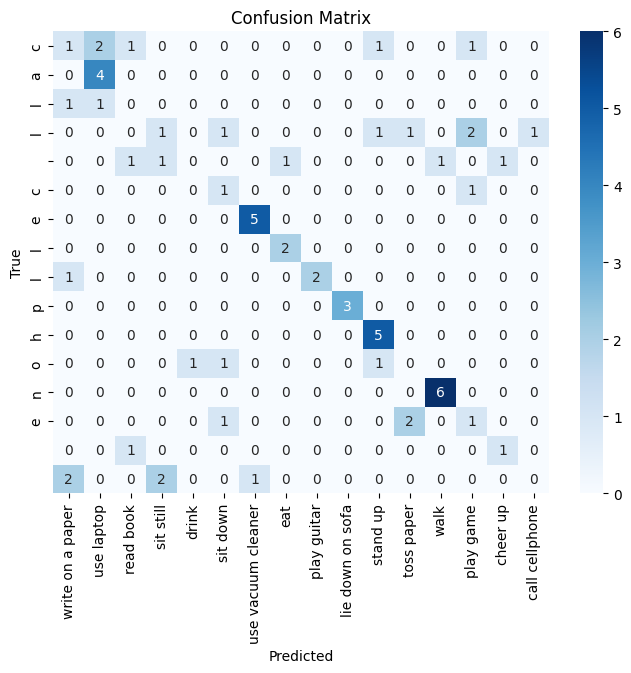

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create test generator with batch_size matching test set size
test_gen = VideoDataGenerator(
    video_frames=features_test,
    labels=labels_test,
    batch_size=4,  # Process all test samples at once
)

# Get predictions
predictions = xlstm_model.predict(test_gen.as_dataset())
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test, axis=1)

# Verify shapes
print(f"True classes shape: {true_classes.shape}")
print(f"Predicted classes shape: {predicted_classes.shape}")
assert len(true_classes) == len(predicted_classes), "Sample counts do not match!"

# Generate classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST[-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()